In [ ]:
import pandas as pd
import numpy as np
# !pip install transformers
# !pip install sentence_transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from transformers import get_scheduler
from sentence_transformers import SentenceTransformer
from datetime import timedelta


import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, trange
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix 
from collections import OrderedDict

from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

In [ ]:
# 不用colab就不要运行这一代码块
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# path = "/content/drive/My Drive/Colab Notebooks/7871project"
# import os
# os.chdir(path)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class simpleProcessor():
    
    def __init__(self, priceFile, newsFile, tickerName, priceType):
        self.tickerName = tickerName
        self.priceType = priceType
        self.news_data = pd.read_csv(newsFile, index_col=[0])
        self.price_vol = pd.read_csv(priceFile, index_col=[0])
        self.crypto_price = self.price_vol[[tickerName + '-' + priceType]]
        self.crypto_news = self.news_data[[tickerName]]
        self.crypto_price.index = pd.to_datetime(self.crypto_price.index).tz_convert(None)
        self.crypto_news.index = pd.to_datetime(self.crypto_news.index)
        self.all_data = None
        self.data = None
    
    def allData(self):
        data = self.crypto_news.merge(self.crypto_price, how = 'inner', left_index = True, right_index = True)
        data[self.tickerName + '_summary'] = data.apply(lambda x :self.joinStr(x), axis = 1)
        data['returns'] = data[self.tickerName + '-' + self.priceType].pct_change().shift(-1)
        data['class'] = data['returns'] > 0
        data = data.iloc[:-1, :]
        self.all_data = data.copy()
        return self.all_data.copy()

    def getData(self):
        data = self.all_data.copy()
        nonewsdate = data[data.isna().any(axis = 1)].index
        newsdate = data[~data.isna().any(axis = 1)].index
        
        self.data = data[~data.isna().any(axis = 1)][[self.tickerName + '_summary', 'class']]
        self.data.columns = ['text', 'class']
        self.data['class'] = self.data['class'].map({True : 1, False : 0})
        
        return self.data.copy()
        
    @staticmethod
    def joinStr(df):
        lists = eval(df[0])
        if(lists[0]):
            return ' '.join(lists[0])
        return np.nan

In [ ]:
class newsDataset(Dataset): 
    
    def __init__(self, df, tokenizer, sentence_vectorizer):
        self.labels = [i for i in df['class']]
        self.texts = [torch.tensor(sentence_vectorizer.encode(text)) for text in df['text']]
        
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_text(self, idx):
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_text(idx)
        batch_labels = self.get_batch_labels(idx)
        
        return batch_texts, batch_labels

In [ ]:
class net(nn.Module):

    def __init__(self, lr, totalSteps):
        super(net, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = nn.Sequential(nn.Linear(384, 256), nn.ReLU(), nn.Linear(256, 2), nn.Dropout(p=0.05), nn.Sigmoid())
        self.model = self.model.to(self.device)
        self.optimizer = AdamW(self.model.parameters(), lr=lr, eps=1e-8)
        self.scheduler = get_scheduler(name='linear', optimizer=self.optimizer, num_warmup_steps=0, 
                                       num_training_steps=totalSteps)
    
    def forward(self, X):
        return self.model(X)

In [ ]:
def trainer(clf, trainLoader, validLoader, epochs, loss):
    #epochs 
    for _ in trange(epochs):
        
        #set model to training model
        clf.model.train()
        
        total_loss = 0
        total_num = 0
        for train_inputs, train_labels in trainLoader:
            
            train_labels = train_labels.long()
            train_labels = train_labels.to(clf.device).reshape(train_inputs.size()[0])
            train_inputs = train_inputs.to(clf.device)
            
            clf.optimizer.zero_grad()

            y_hat = clf(train_inputs).reshape(train_inputs.size()[0], 2)
            loss = loss.to(clf.device)
            l = loss(y_hat, train_labels)
            l.backward()
                        
            clf.optimizer.step()
            clf.scheduler.step()
            
            # total_loss += l.item()
            total_loss += l
            total_num += train_inputs.size()[0]
            
        # Validation
        clf.model.eval()
        
        total_loss_val = 0
        total_num_val = 0
        preds = []
        trues = []
        with torch.no_grad():
            
            for valid_inputs, valid_labels in validLoader:
                
                valid_labels = valid_labels.long()
                valid_labels = valid_labels.to(clf.device).reshape(valid_inputs.size()[0])
                valid_inputs = valid_inputs.to(clf.device)
                
                y_hat = clf(valid_inputs).reshape(valid_inputs.size()[0], 2)
                l = loss(y_hat, valid_labels)
                total_loss_val += l
                total_num_val += valid_inputs.size()[0]

                y_hat1 = y_hat.detach().cpu().numpy()
                predictions = np.argmax(y_hat1, axis=1).flatten()
                labels = valid_labels.detach().cpu().numpy().flatten()
                
                preds += list(predictions)
                trues += list(labels)

        print('\n\t - Train loss : {:.4f}'.format(total_loss / total_num))
        print('\t - Validation loss : {:.4f}'.format(total_loss_val / total_num_val))
        print('\t - Validation accuracy : {:.4f}'.format(accuracy_score(trues, preds)))
        print('\t - Validation precision : {:.4f}'.format(precision_score(trues, preds)))
        print('\t - Validation recall : {:.4f}'.format(recall_score(trues, preds)))
        if _ == epochs - 1:
            print('preds: ', preds)
            print('trues: ', trues)

In [ ]:
def predict_test(clf, testLoader, loss):
    # Test
    clf.model.eval()

    total_loss_test = 0
    total_num_test = 0
    preds = []
    trues = []
    with torch.no_grad():

        for test_inputs, test_labels in testLoader:

            test_labels = test_labels.long()
            test_labels = test_labels.to(clf.device).reshape(test_inputs.size()[0])
            test_inputs = test_inputs.to(clf.device)

            y_hat = clf(test_inputs).reshape(test_inputs.size()[0], 2)
            l = loss(y_hat, test_labels)
            total_loss_test += l
            total_num_test += test_inputs.size()[0]

            y_hat1 = y_hat.detach().cpu().numpy()
            predictions = np.argmax(y_hat1, axis=1).flatten()
            labels = test_labels.detach().cpu().numpy().flatten()

            preds += list(predictions)
            trues += list(labels)

    print('\t - test loss : {:.4f}'.format(total_loss_test / total_num_test))
    print('\t - test accuracy : {:.4f}'.format(accuracy_score(trues, preds)))
    print('\t - test precision : {:.4f}'.format(precision_score(trues, preds)))
    print('\t - test recall : {:.4f}'.format(recall_score(trues, preds)))
    print('preds: ', preds)
    print('trues: ', trues)
            
    return preds, trues

In [ ]:
coin_name = 'ADA'
sp = simpleProcessor('price_vol.csv', 'news.csv', coin_name, 'close')
all_data = sp.allData()
train_data1 = sp.getData()
percent = 0.8
n = train_data1.shape[0]
trainData, testData = train_data1.iloc[0 : int(n*percent)], train_data1.iloc[int(n*percent):]
m = trainData.shape[0]
trainData, validData = trainData.iloc[0 : int(m*percent)], trainData.iloc[int(m*percent): ]

BERT_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_NAME)
# sentence_vectorizer = BertModel.from_pretrained(BERT_NAME)
sentence_vectorizer = SentenceTransformer('all-MiniLM-L6-v2')
trainDataLoader = DataLoader(newsDataset(trainData, tokenizer, sentence_vectorizer), batch_size=16)
validDataLoader = DataLoader(newsDataset(validData, tokenizer, sentence_vectorizer), batch_size=16)
testDataLoader = DataLoader(newsDataset(testData, tokenizer, sentence_vectorizer), batch_size=16)

In [ ]:
num_epochs = 5
loss = nn.CrossEntropyLoss()
clf = net(lr=3e-6, totalSteps=num_epochs * len(trainDataLoader))
trainer(clf, trainDataLoader, validDataLoader, num_epochs, loss)

In [ ]:
preds, trues = predict_test(clf, testDataLoader, loss)

In [ ]:
cm_test = confusion_matrix(trues, preds, labels=[1, 0])
plt.figure(figsize=(6, 6), dpi=100)
s = sns.heatmap(cm_test, annot= True, fmt = 'd', annot_kws={'size': 16}, 
                cmap ='YlGnBu', xticklabels=[1, 0], yticklabels=[1, 0])
_ = s.set_xlabel('Predicted')
_ = s.set_ylabel('True')
_ = s.set_title('Confusion Matrix of test set of ' + coin_name)

In [70]:
preds, trues = predict_test(clf, testDataLoader, loss)

	 - test loss : 0.0465
	 - test accuracy : 0.5366
	 - test precision : 0.5473
	 - test recall : 0.9000
preds:  [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
trues:  [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 

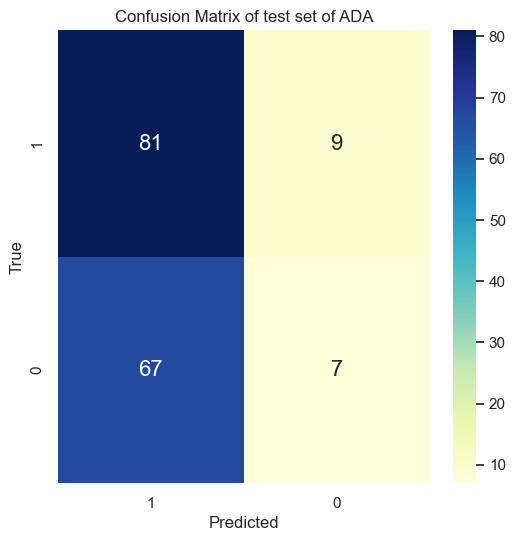

In [83]:
cm_test = confusion_matrix(trues, preds, labels=[1, 0])
plt.figure(figsize=(6, 6), dpi=100)
s = sns.heatmap(cm_test, annot= True, fmt = 'd', annot_kws={'size': 16}, 
                cmap ='YlGnBu', xticklabels=[1, 0], yticklabels=[1, 0])
_ = s.set_xlabel('Predicted')
_ = s.set_ylabel('True')
_ = s.set_title('Confusion Matrix of test set of ' + coin_name)

In [80]:
testData['pred_label'] = np.asarray(preds)
bt_data = all_data.loc[testData.index[0]:, ['returns']].merge(testData[['class', 'pred_label']], left_index=True, right_index=True, how='left')
bt_data.ffill(inplace=True)
bt_data['strat_ret'] = bt_data['returns'] * bt_data['pred_label']
bt_data['nav'] = np.cumprod(1 + bt_data['returns'])
bt_data['strat_nav'] = np.cumprod(1 + bt_data['strat_ret'])
bt_data.head()

,returns,class,pred_label,strat_ret,nav,strat_nav
2022-08-08 11:00:00,-0.005147,0.0,1.0,-0.005147,0.994853,0.994853
2022-08-08 12:00:00,0.001406,0.0,1.0,0.001406,0.996252,0.996252
2022-08-08 13:00:00,-0.010338,0.0,1.0,-0.010338,0.985953,0.985953
2022-08-08 14:00:00,-0.008236,0.0,1.0,-0.008236,0.977833,0.977833
2022-08-08 15:00:00,-0.001892,0.0,1.0,-0.001892,0.975983,0.975983


In [81]:
class backtest_metrics:
    
    def __init__(self, coin_name, df, col1, col2):
        self.name = coin_name
        self.nav = df[[col1, col2]]
        self.nav = pd.concat([pd.DataFrame([[1.0, 1.0]], index=[self.nav.index[0] - timedelta(hours=1)], columns=[col1, col2]), self.nav])
        self.ret = (df - df.shift(1))/df.shift(1)
        self.N = len(df) - 1
        self.metrics = pd.DataFrame([], columns=[col1, col2])
        
    def get_return(self):
        self.metrics.loc['annualized return'] = (np.power(self.nav.iloc[-1, :] / self.nav.iloc[0, :], 365*24 / self.N) - 1)
    
    def get_vol(self):
        self.metrics.loc['annualized std'] = (np.std(self.ret)*np.sqrt(365*24))
    
    def get_sharpe(self):
        self.metrics.loc['sharpe ratio'] = self.metrics.loc['annualized return'] / self.metrics.loc['annualized std']
    
    def get_cumReturn(self):
        self.metrics.loc['accumulated return'] = (self.nav.iloc[-1,:]/self.nav.iloc[0,:] - 1)
    
    def get_maxdd(self):
        self.metrics.loc['maximum drawdown'] = ((np.maximum.accumulate(self.nav) - self.nav) / np.maximum.accumulate(self.nav)).max()
        
    def get_metrics(self):
        self.get_return()
        self.get_vol()
        self.get_sharpe()
        self.get_cumReturn()
        self.get_maxdd()
        return self.metrics
    
    def nav_curve(self, output=False):
        plt.figure(figsize=(10, 5), dpi=300)
        plt.title(self.name)
        plt.plot(self.nav['nav'], label="nav")
        plt.plot(bt_data['strat_nav'], label='strat_nav')
        plt.legend(fontsize=10)
        if output:
            plt.savefig(coin_name + '.jpg')

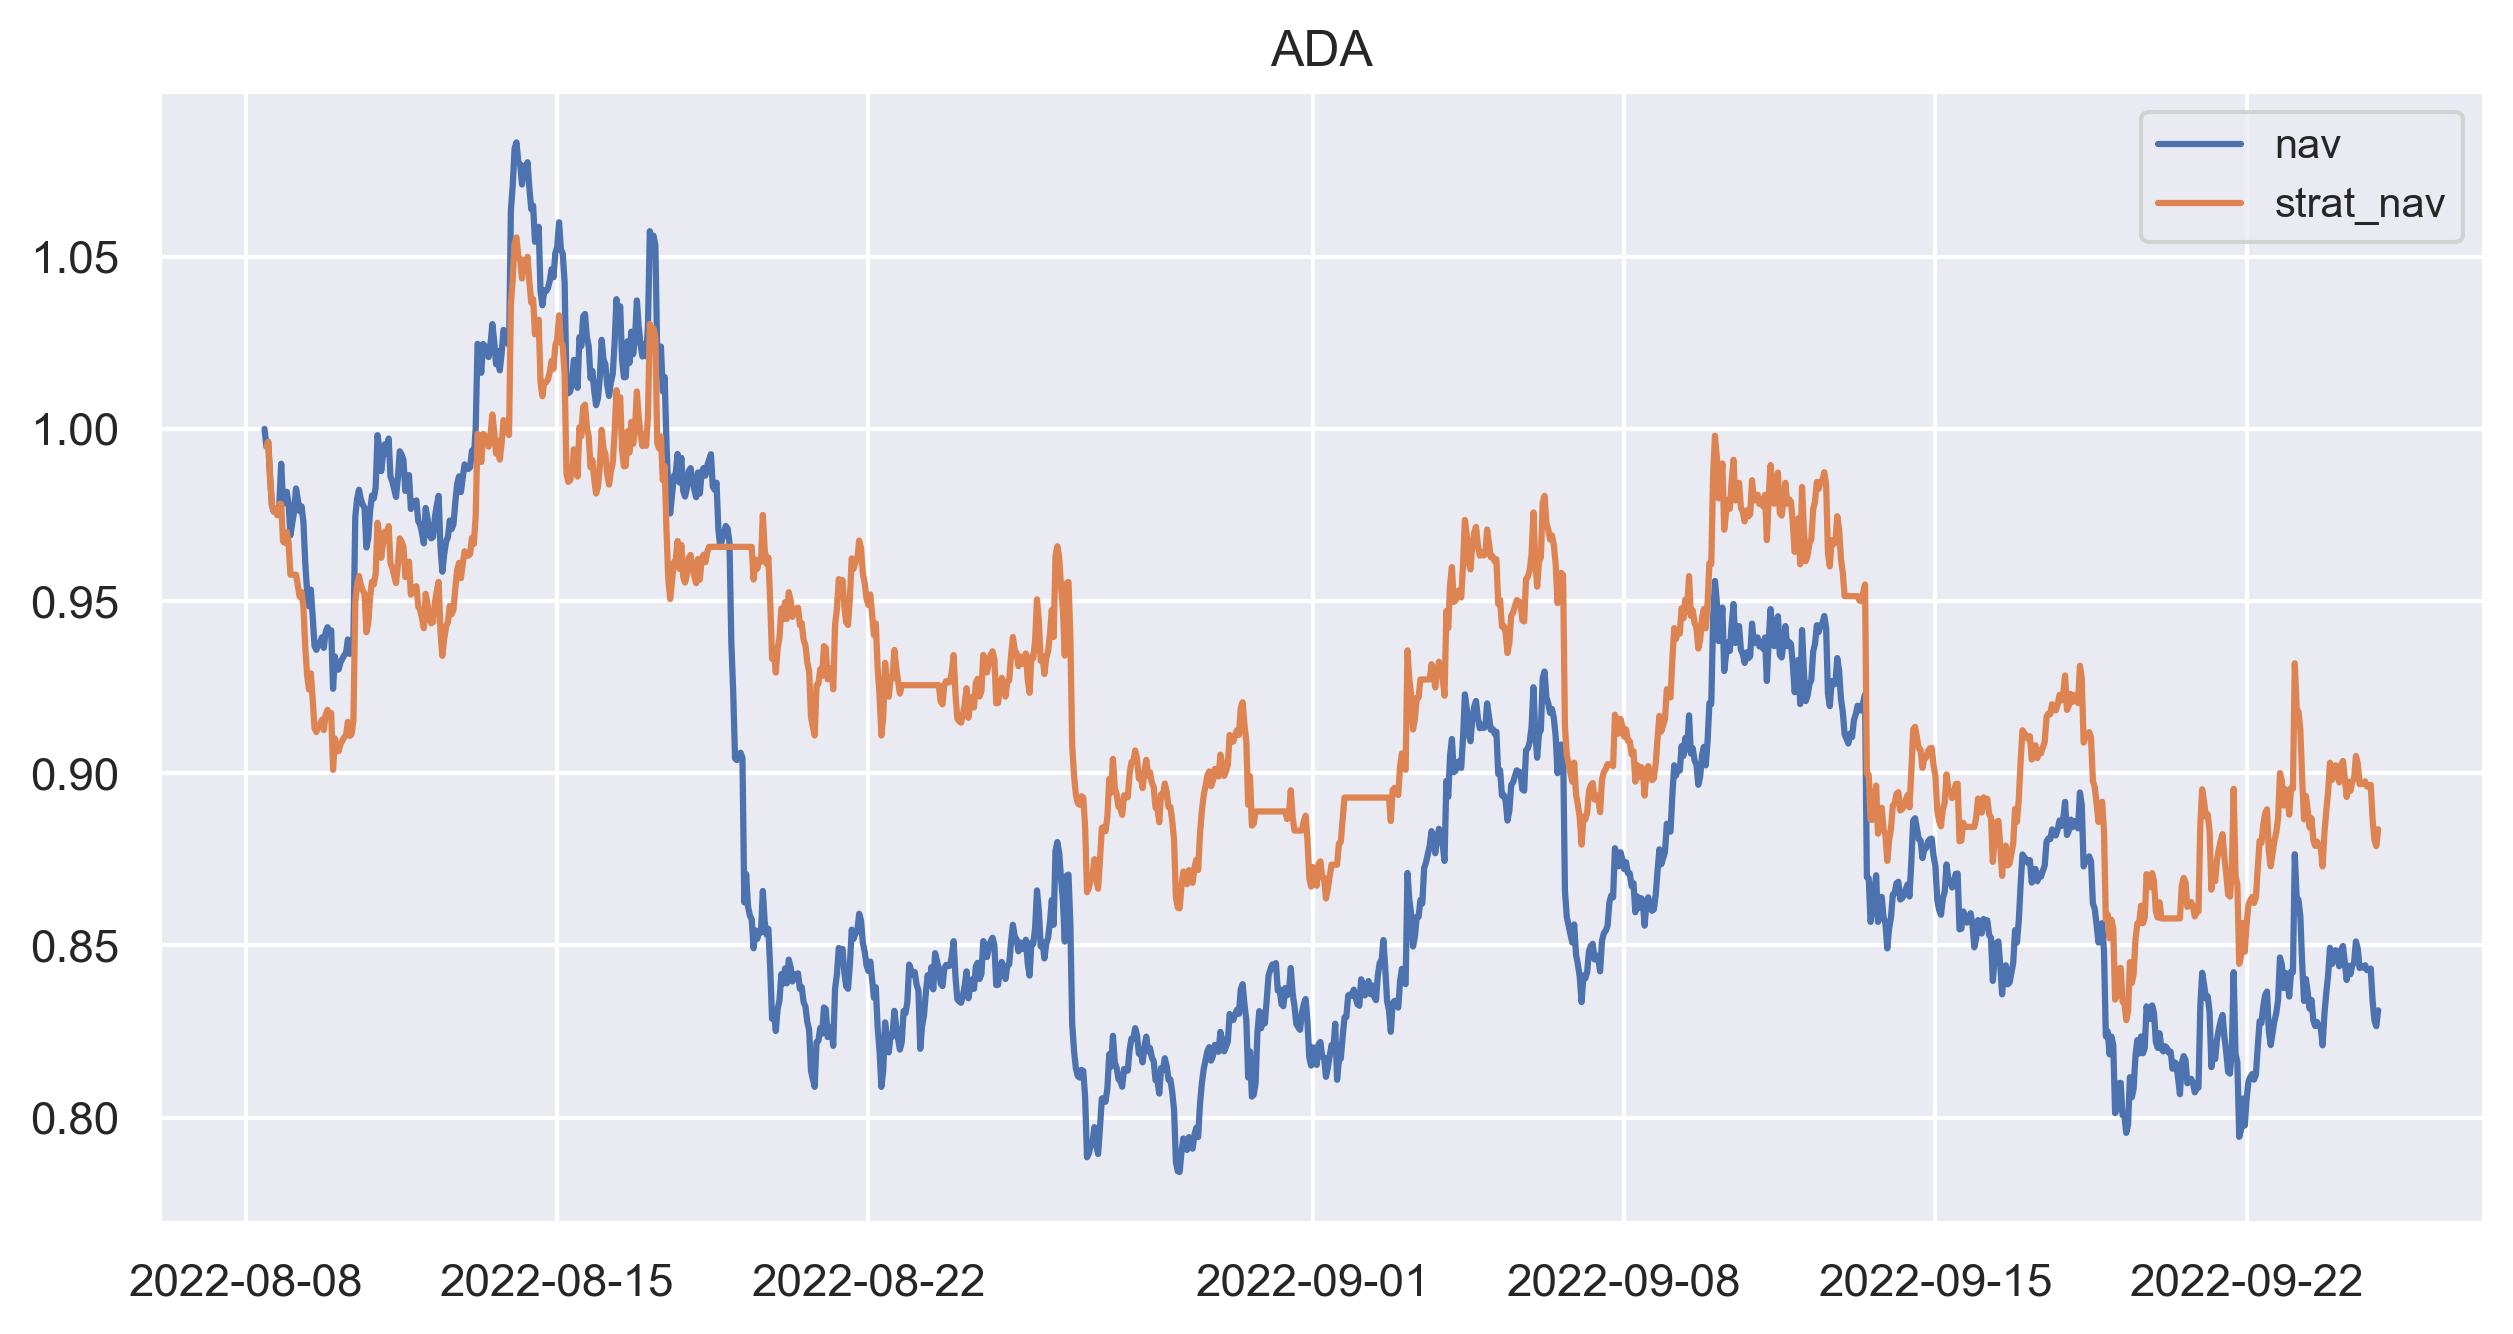

In [82]:
bt = backtest_metrics(coin_name, bt_data, 'nav', 'strat_nav')
bt.get_metrics()
bt.nav_curve()

In [15]:
bt.get_metrics()

,nav,strat_nav
annualized return,-0.758540,-0.758540
annualized std,0.737154,0.737154
sharpe ratio,-1.029012,-1.029012
accumulated return,-0.168839,-0.168839
maximum drawdown,0.275993,0.275993


In [16]:
# with pd.ExcelWriter(coin_name + ".xlsx") as writer:
#     bt.nav.to_excel(writer, sheet_name="nav")  
#     bt.metrics.to_excel(writer, sheet_name="metrics")